In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from AReS import Simulator, SimulatorMode, Model, TciMode, DoHMeasure, Interaction, VolumeStatus

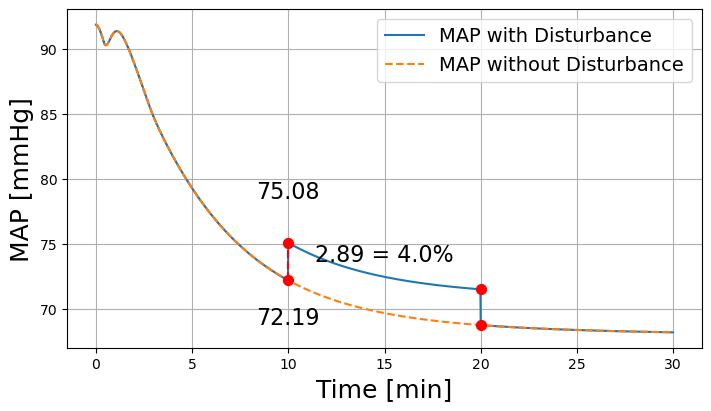

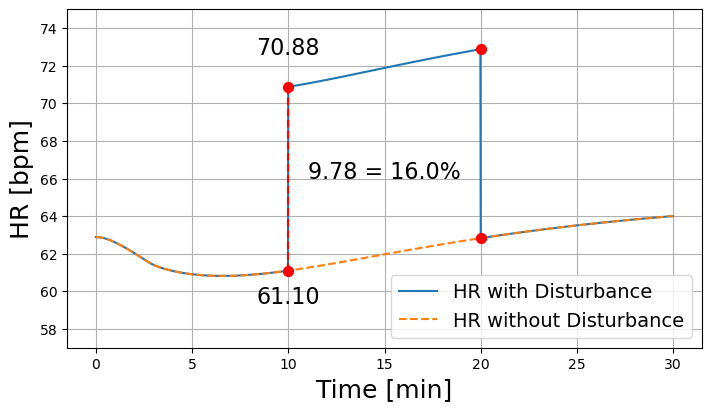

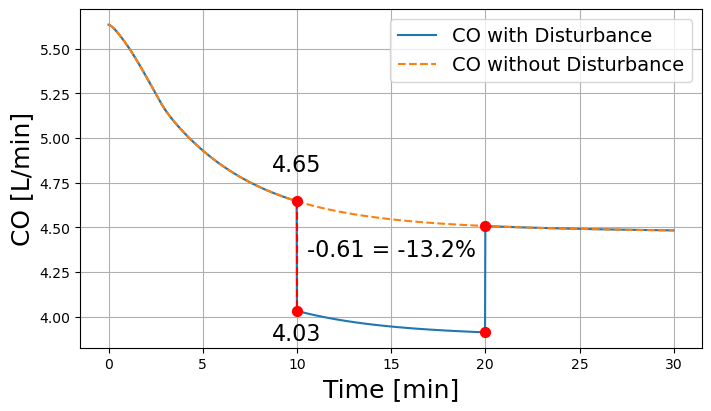

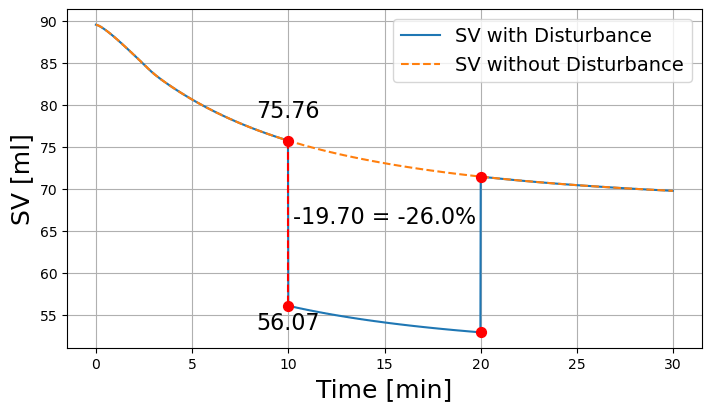

In [2]:
simulator = Simulator.create(SimulatorMode.CONCENTRATION)
interaction = Interaction.SURFACE
dohMeasure = DoHMeasure.BOTH
t_sim = 60 * 30
t_s = 5

pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}
pd_models = {'prop': Model.PATIENT_SPECIFIC, 'remi': Model.ELEVELD}

limits_TCI = {'cp_limit_prop': 10, 'cp_limit_remi': 10, 'infusion_limit_prop': 2,
              'infusion_limit_remi': 0.5}

modes_TCI = {'prop': TciMode.EFFECT_SITE, 'remi': TciMode.EFFECT_SITE}

t_prop = [2.0] * t_sim
t_remi = [3.6] * t_sim
t_nore = [0.5] * t_sim
t_rocu = [0.0] * t_sim

volume_status = {
    10 * 60: VolumeStatus.HYPOVOLEMIA,
    20 * 60: VolumeStatus.NORMOVOLEMIA
}

names = {
    '_MAP_all': 'MAP [mmHg]',
    '_HR_all': 'HR [bpm]',
    '_CO_all': 'CO [L/min]',
    '_SV_all': 'SV [ml]',
}

labels = {
    '_MAP_all': 'MAP',
    '_HR_all': 'HR',
    '_CO_all': 'CO',
    '_SV_all': 'SV',
}

patient_id = 29
for idx, k in enumerate([patient_id, patient_id]):
    is_disturbed = (idx % 2 == 0)

    current_volume_status = volume_status if is_disturbed else None

    simulator.init_simulation_from_file(
        id_patient=k,
        t_sim=t_sim,
        t_s=t_s,
        pk_models=pk_models,
        pd_models=pd_models,
        pk_models_TCI=pk_models,
        pd_models_TCI=pd_models,
        modes_TCI=modes_TCI,
        interaction=interaction,
        doh_measure=dohMeasure,
        seed_disturbance=42,
        volume_status=current_volume_status,
    )

    simulator.run_complete_simulation(t_prop, t_remi, t_nore, t_rocu)
    simulator.save_simulation()

# Fetch all results after simulations
results = simulator.get_patient_results()

num_samples = len(results['_MAP_all'][0])
t = np.arange(num_samples) / 60


for key in ['_MAP_all', '_HR_all', '_CO_all', '_SV_all']:
    for i in range(0, 2, 2):
        fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)
        ax.plot(t, results[key][i], label=f"{labels[key]} with Disturbance")
        ax.plot(t, results[key][i + 1], label=f"{labels[key]} without Disturbance", linestyle='--')
        
        if key in ['_HR_all']:
            ax.set_ylim(57, 75)
           
        for start in volume_status:
            x = start / 60
            y_dis = results[key][i][start]
            y_no_dis = results[key][i + 1][start]
            if volume_status[start] == VolumeStatus.HYPOVOLEMIA:  
                ax.vlines(x=x, ymin=y_no_dis, ymax=y_dis, color='red', linestyle='--')

                if key in ['_SV_all', '_CO_all']:
                    delta = -((max(results[key][i]) - min(results[key][i + 1])) / 7)
                else:
                    delta = ((max(results[key][i]) - min(results[key][i + 1])) / 7)

                percentage = (results[key][i][start] / results[key][i + 1][start] * 100) -100
                ax.text(x, y_dis + delta, f"{y_dis:.2f}", color='black', fontsize=16, ha='center')
                ax.text(x, y_no_dis - delta, f"{y_no_dis:.2f}", color='black', fontsize=16, ha='center')
                ax.text(x + 5, y_no_dis + (y_dis - y_no_dis) / 2, f"{(y_dis - y_no_dis):.2f} = {percentage:.1f}%",
                        color='black', fontsize=16, ha='center')

            if volume_status[start] == VolumeStatus.NORMOVOLEMIA:
                y_dis = results[key][i][start-1]
            ax.scatter(x, y_dis, color='red', s=50, marker='o',zorder=3)
            ax.scatter(x, y_no_dis, color='red', s=50, marker='o', zorder=3)

        ax.set_xlabel('Time [min]', fontsize=18)
        ax.set_ylabel(names[key], fontsize=18)
        ax.legend(fontsize=14)
        ax.grid(True)
        fig.savefig(f"{labels[key]}_with_and_without_hypovolemia.pdf", dpi=300)
        plt.show()
